In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import pdb
from tqdm import tqdm
import pandas as pd
import pickle
import io
import os
import sacrebleu
from sacrebleu import raw_corpus_bleu, corpus_bleu

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# In[2]:
PAD_idx = 0
SOS_idx = 1
EOS_idx = 2
UNK_idx= 3
batch_size = 64
MAX_SENTENCE_LENGTH = 50

In [3]:
class language(object):
    def __init__(self, name, i2t, t2i, embedding_matrix, train, test, val):
        self.name = name
        self.idx2token = i2t
        self.token2idx = t2i
        self.embedding_mat = embedding_matrix
        self.train_idx = train
        self.test_idx = test
        self.val_idx = val
        
dataset = pickle.load(open("./zh1.1w-en6k.p", 'rb'))

class LanguageDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, source_lan, translate_lan):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.source_lan = source_lan
        self.translate_lan = translate_lan
        
        assert (len(self.source_lan) == len(self.translate_lan))

    def __len__(self):
        return len(self.source_lan)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        source_lan_idx = self.source_lan[key][:MAX_SENTENCE_LENGTH-1]
        translation_lan_idx = self.translate_lan[key][:MAX_SENTENCE_LENGTH-1]
        source_lan_idx.append(EOS_idx)
        translation_lan_idx.append(EOS_idx)
        
        return [source_lan_idx, translation_lan_idx, len(source_lan_idx), len(translation_lan_idx)]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    source_list = []
    translate_list = []
    length_list = []
    
    # padding
    for datum in batch:

        length_list.append(datum[2])
        s_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=PAD_idx)
        source_list.append(s_padded_vec)
        t_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=PAD_idx)
        translate_list.append(t_padded_vec)
        
#     ind_dec_order = np.argsort(length_list)[::-1]
#     source_list = np.array(source_list)[ind_dec_order]
#     length_list = np.array(length_list)[ind_dec_order]
#     translate_list = np.array(translate_list)[ind_dec_order]
    
    if torch.cuda.is_available and torch.has_cudnn:
        return [torch.from_numpy(np.array(source_list)).cuda(),torch.from_numpy(np.array(translate_list)).cuda()]
    else:
        return [torch.from_numpy(np.array(source_list)),torch.from_numpy(np.array(translate_list))]

In [4]:
train_dataset = LanguageDataset(dataset['src'].train_idx, dataset['tgt'].train_idx)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

# s_train_dataset = LanguageDataset(train_zh_indicies[2000:2500], train_en_indicies[2000:2500])
# s_train_loader = torch.utils.data.DataLoader(dataset=s_train_dataset,
#                                            batch_size=batch_size,
#                                            collate_fn=vocab_collate_func,
#                                            shuffle=True)

val_dataset = LanguageDataset(dataset['src'].val_idx, dataset['tgt'].val_idx)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

test_dataset = LanguageDataset(dataset['src'].test_idx, dataset['tgt'].test_idx)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [5]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''
    def __init__(self, sqrt_dim, attn_dropout=0.1):
        super().__init__()
        self.sqrt_dim = sqrt_dim
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, query, k, v, mask=None):
#         Dot product in batch
#         pdb.set_trace()
        attn = torch.bmm(query, k.transpose(1, 2))
#         Rescaling
        attn = attn / self.sqrt_dim
#         Masking
        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)
#         Normalize attention
        attn = self.softmax(attn)
# ------------ Notice dropout was added -------------
        attn = self.dropout(attn)
    
        output = torch.bmm(attn, v)

        return output, attn
# In[ ]:


class EncoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim):
        super(EncoderRNN, self).__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(dataset['src'].embedding_mat), freeze=False)
        self.dropout = nn.Dropout(p=0.3)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True, bidirectional=True)

    def forward(self, inputs, hidden):
        encode_batch_size, length = inputs.size()
        embedded = self.dropout(self.embedding(inputs).float()) # the size -1 is inferred from other dimensions
        output, hidden = self.gru(embedded, hidden)
        hidden = torch.cat((hidden[0:1,:,:], hidden[1:2,:,:]),2)
        return output, hidden

    def init_hidden(self, encode_batch_size):
        
        return torch.rand(2, encode_batch_size, self.hid_dim, device=device)
# In[ ]:

class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, output_dim, dropout_rate=0.3):
        super(DecoderRNN, self).__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(dataset['tgt'].embedding_mat), freeze=False)
        
        self.mapping = nn.Linear(self.emb_dim+self.hid_dim, self.hid_dim)
#         self.attn_combine = nn.Linear(self.hid_dim + self.emb_dim, self.emb_dim)
        self.dot_product_att = ScaledDotProductAttention(sqrt_dim=emb_dim)
        
        self.gru = nn.GRU(emb_dim+hid_dim, hid_dim)
        self.out = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, hidden, encoder_outputs):
        
        emb = self.dropout(self.embedding(inputs).float())
        
        attn_keys = self.mapping(torch.cat((emb, hidden), dim=2))
        
#         attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        output, attention = self.dot_product_att(attn_keys[0].unsqueeze(0).transpose(0,1), encoder_outputs, encoder_outputs)

#         output = torch.cat((emb[0], attn_applied.squeeze(1)), 1)
#         output = self.attn_combine(output).unsqueeze(0)
#         output = F.relu(output)
        
#         pdb.set_trace()
        output, hidden = self.gru(torch.cat((emb, output.transpose(0,1)), dim=2), hidden)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden, attention


In [6]:
teacher_forcing_ratio = 1
#input_tensor: list of sentence tensor
def train(source, translate, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion):
    encoder.train()
    decoder.train()
    
    cur_batch_size, input_length = source.size()
    cur_batch_size, target_length = translate.size()
    
    
    encoder_hidden = encoder.init_hidden(cur_batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0

    encoder_output, encoder_hidden = encoder(source, encoder_hidden)

    decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for i in range(target_length):
        
            
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            
            loss += criterion(decoder_output, translate[:,i])
            decoder_input = translate[:,i].unsqueeze(0)  # Teacher forcing
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for i in range(target_length):
            decoder_output, decoder_hidden, decoder_attention= decoder(decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            #decoder_input [1, batch size] 
            decoder_input = decoder_input.unsqueeze(0)
 
            loss += criterion(decoder_output, translate[:,i])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [7]:
def compute_corpus_bleu(output_words, target_words):
    output_sentence = [' '.join(parser(words)) for words in output_words]
    target_sentence = [' '.join(parser(words)) for words in target_words]
    
#     ref_sent_list = [[i.split()] for i in target_sentence]
#     candidate_sent_list = [i.split() for i in output_sentence]
    ref_sent_list = [[i for i in target_sentence]]
    candidate_sent_list = [i for i in output_sentence]
#     pdb.set_trace()
#     score = corpus_bleu(ref_sent_list, candidate_sent_list, smoothing_function=chencherry.method1)
    score = raw_corpus_bleu(candidate_sent_list, ref_sent_list)
    
    return score


# In[ ]:


def evaluate2(encoder, decoder, loader):
    encoder.eval()
    decoder.eval()
    input_words = []
    target_words = []
    decoded_words = []
    num_count = 0
    num_count = 0
    for i, (source, translate) in enumerate(loader):
        
        if i > 20:
            break
        
        cur_batch_size = translate.size()[0]
            
        with torch.no_grad():
            encoder_hidden = encoder.init_hidden(cur_batch_size)
        
        input_tensor = source
        target_tensor = translate
        target_length = target_tensor.size()[1]
        
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
        decoder_hidden = encoder_hidden
        
        for i in range(cur_batch_size):
            decoded_words.append([])
            input_words.append([])
            target_words.append([])
        
        for i in range(cur_batch_size):
            for ii in range(input_tensor.size()[1]):
                if dataset['src'].idx2token[input_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    input_words[num_count].append(dataset['src'].idx2token[input_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size
        for i in range(cur_batch_size):
            for ii in range(target_tensor.size()[1]):
                if dataset['tgt'].idx2token[target_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    target_words[num_count].append(dataset['tgt'].idx2token[target_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size      
        
        cur_len = np.zeros(cur_batch_size, dtype=int)
        #pdb.set_trace()
        for i in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = decoder_input.unsqueeze(0)
            
            topi = topi.squeeze().cpu().numpy()
            if cur_len[0] == 0:
                for i in range(len(topi)):
                    decoded_words[num_count+i].append(dataset['tgt'].idx2token[topi[i]])
                    cur_len[i] += 1
            
            else:
                for i in range(len(topi)):
                    if decoded_words[num_count+i][cur_len[i]-1] == '<EOS>':
                        continue
                    decoded_words[num_count+i].append(dataset['tgt'].idx2token[topi[i]])
                    cur_len[i] += 1
        num_count += cur_batch_size
    pre_list = []
    for pre_sentenc in decoded_words:
        pre_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in pre_sentenc]).strip())

    true_list = []
    for true_sentenc in target_words:
        true_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in true_sentenc]).strip())
    
    true_list2 = []
    true_list2.append(true_list)        
    score = sacrebleu.corpus_bleu(pre_list, true_list2)
    print('bleu score: ', score.score)
    return decoded_words,input_words, target_words, score

In [8]:
def trainIters(encoder, decoder, n_iters, print_every=800, plot_every=200, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss(ignore_index = 0)
    count_iter = 0
    for cur_iter in range(1, n_iters + 1):
        for i, (source, translate) in tqdm(enumerate(train_loader) ,total=3334):
            
            loss = train(source, translate, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss
            count_iter += 1
            
            if count_iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
#             if count_iter % print_every == 0:
        
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('%d %d%% %.4f' % (cur_iter, cur_iter / n_iters * 100, print_loss_avg))

        print('Train: ')
        _,_,_, score = evaluate2(encoder, decoder, train_loader)
        with open('out4.txt', 'a') as file:
            file.write('small train: ' + str(score.score) + '\n')

        print('validation: ')
        _,_,_, score = evaluate2(encoder, decoder, val_loader)
        with open('out4.txt', 'a') as file:
            file.write('validation: ' + str(score.score) + '\n')


In [9]:
# In[ ]:


import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
# get_ipython().run_line_magic('matplotlib', 'inline')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [10]:
ENC_EMB_DIM = 300
ZH_EMB_DIM = 300
HID_DIM = 256
OUTPUT_DIM = len(dataset['tgt'].token2idx)


encoder = EncoderRNN(ENC_EMB_DIM, HID_DIM).to(device)
decoder = DecoderRNN(ZH_EMB_DIM, HID_DIM*2, OUTPUT_DIM).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('False, False, corpus_bleu') 

False, False, corpus_bleu


In [ ]:
trainIters(encoder, decoder, 60)

In [ ]:
# torch.save(encoder.state_dict(), './model/encoder_stable_ATT2_sub.pth')
# torch.save(decoder.state_dict(), './model/decoder_stable_ATT2_sub.pth')

In [11]:
encoder.load_state_dict(torch.load('./model/encoder_stable_ATT2_zhipeng.pth'))
decoder.load_state_dict(torch.load('./model/decoder_stable_ATT2_zhipeng.pth'))

In [16]:
# evaluate2(encoder, decoder, train_loader)
# evaluate2(encoder, decoder, val_loader)
decoded_words,input_words, target_words, score = evaluate2(encoder, decoder, test_loader)

bleu score:  23.583745834717167


In [17]:
for i in range(len(decoded_words)):
    print('source: ', input_words[i])
    print('target: ', target_words[i])
    print('predict: ', decoded_words[i])

source:  ['你好', '我', '是', '凯文', '<UNK>', '卡', '我', '是', 'YouTube', '的', '趋势', '分析', '经理', '而', '我', '的', '专业', '就是', '观看', 'YouTube', '视频', '<EOS>']
target:  ['hi', '.', 'i', 'apos', 'm', 'kevin', '<UNK>', 'i', 'apos', 'm', 'the', 'trends', 'manager', 'at', 'youtube', 'and', 'i', '<UNK>', 'watch', 'youtube', 'videos', '.', '<EOS>']
predict:  ['hello', 'i', 'apos', 'm', 'a', '<UNK>', '<UNK>', 'i', 'apos', 'm', 'the', 'search', 'of', 'the', 'web', 'and', 'my', 'professional', 'is', 'the', 'video', '.', '<EOS>']
source:  ['这', '是', '真的', '<EOS>']
target:  ['it', 'apos', 's', 'true', '.', '<EOS>']
predict:  ['this', 'is', 'real', '.', '<EOS>']
source:  ['所以', '今天', '我们', '要', '讨论', '<UNK>', '一下', '<UNK>', '为什么', '什么', '一些', '视频', '<UNK>', '<UNK>', '甚至', '会', '变得', '重要', '<EOS>']
target:  ['so', 'we', 'apos', 're', 'going', 'to', 'talk', 'a', 'little', 'bit', 'today', 'about', 'how', 'videos', 'go', 'viral', 'and', 'then', 'why', 'that', 'even', 'matters', '.', '<EOS>']
predict:  ['so', 'no

target:  ['and', 'this', 'has', 'spread', 'just', '<UNK>', '<UNK>', 'naturally', '.', '<EOS>']
predict:  ['it', 'apos', 's', 'a', 'natural', '<UNK>', 'that', 'we', 'apos', 've', 'got', 'in', 'nature', '.', '<EOS>']
source:  ['如果', '你', '对', '政府', '的', '科技', '有些', '了解', '你', '会', '知道', '这', '并', '不是', '普遍', '的', '结果', '<EOS>']
target:  ['if', 'you', 'know', 'anything', 'about', 'government', 'technology', 'you', 'know', 'that', 'this', 'isn', 'apos', 't', 'how', 'it', 'normally', 'goes', '.', '<EOS>']
predict:  ['if', 'you', 'apos', 're', 'about', 'the', 'technology', 'of', 'government', 'some', 'of', 'you', 'know', 'that', 'it', 'apos', 's', 'not', 'a', '<UNK>', 'outcome', '.', '<EOS>']
source:  ['开发', '<UNK>', '完成', '一个', '软件', '往往', '需要', '几年', '<EOS>']
target:  ['<UNK>', 'software', 'usually', 'takes', 'a', 'couple', 'of', 'years', '.', '<EOS>']
predict:  ['the', 'software', '<UNK>', 'is', 'a', 'software', 'that', 'we', 'need', 'several', 'years', '.', '<EOS>']
source:  ['去年', '我们',

predict:  ['and', 'then', 'she', 'said', 'quot', 'you', 'apos', 're', 'a', 'baby', '.', 'quot', '<UNK>', '<EOS>']
source:  ['她', '说', '我', '确信', '你', '是', '无所', '<UNK>', '不能', '的', '<EOS>']
target:  ['she', 'said', 'quot', 'i', 'think', 'you', 'can', 'do', 'anything', 'you', 'want', 'to', 'do', '.', 'quot', '<UNK>', '<EOS>']
predict:  ['and', 'she', 'said', 'quot', 'i', 'apos', 'm', 'sure', 'you', 'apos', 're', 'no', '.', 'quot', '<UNK>', '<EOS>']
source:  ['这', '我', '永远', '不会', '忘记', '<EOS>']
target:  ['i', 'will', 'never', 'forget', 'it', '.', '<EOS>']
predict:  ['and', 'i', 'never', 'forget', '.', '<EOS>']
source:  ['接着', '她', '说', '我', '想', '让', '你', '向', '我', '保证', '三件', '事', '<EOS>']
target:  ['and', 'then', 'she', 'said', 'quot', 'i', 'just', 'need', 'you', 'to', 'promise', 'me', 'three', 'things', '<UNK>', '.', 'quot', '<UNK>', '<EOS>']
predict:  ['and', 'then', 'she', 'said', 'quot', 'i', 'want', 'you', 'to', 'give', 'you', 'three', 'things', '.', '<EOS>']
source:  ['我', '说', 

target:  ['societal', '<UNK>', '.', 'dead', '.', '<EOS>']
predict:  ['<UNK>', '<UNK>', 'six', 'seven', 'people', 'died', '.', '<EOS>']
source:  ['<UNK>', '<UNK>', '8', '海啸', '警告', '<UNK>', '<UNK>', '9', '网络', '<UNK>', '攻击', '<EOS>']
target:  ['tsunami', 'warning', '.', 'cyber', 'attacks', '.', '<EOS>']
predict:  ['<UNK>', 'eight', '<UNK>', 'eight', '<UNK>', '<UNK>', 'stations', '.', '<EOS>']
source:  ['<UNK>', '<UNK>', '<UNK>', '毒品', '战争', '大规', '大规模', '规模', '破坏', '飓风', '<EOS>']
target:  ['drug', 'war', '.', 'mass', 'destruction', '.', '<UNK>', '.', '<EOS>']
predict:  ['<UNK>', '<UNK>', 'drugs', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', 'destruction', '.', '<EOS>']
source:  ['经济', '<UNK>', '衰退', '<UNK>', '末日', '埃及', '叙利亚', '利亚', '<EOS>']
target:  ['recession', '.', 'default', '.', '<UNK>', '.', 'egypt', '.', 'syria', '.', '<EOS>']
predict:  ['the', 'recession', 'was', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '.', '<EOS>']
source:  ['危机', '死亡', '灾难', '<

predict:  ['in', 'my', '<UNK>', 'medical', '<UNK>', 'and', 'journalism', 'from', 'my', '<UNK>', 'ed', '<UNK>', 'i', 'could', 'study', 'everything', 'from', '<UNK>', '<UNK>', 'medical', 'care', 'in', '<UNK>', '.', '<EOS>']
source:  ['而', '我', '所学', '学到', '的', '便是', '错误', '绝对', '是', '无处', '无处不在', '不在', '<EOS>']
target:  ['and', 'what', 'i', 'apos', 've', 'learned', 'is', 'that', 'errors', 'are', 'absolutely', 'ubiquitous', '.', '<EOS>']
predict:  ['and', 'what', 'i', 'learned', 'is', 'that', 'it', 'apos', 's', 'not', 'ubiquitous', '.', '<EOS>']
source:  ['我们', '工作', '在', '一个', '每天', '天都', '会', '发生', '错误', '的', '制度', '中', '医院', '有', '十分', '十分之一', '之一', '的', '几率', '会', '给', '错', '药', '或者', '给', '了', '错误', '的', '剂量', '而', '在', '医院', '<UNK>', '被', '传染', '的', '病例', '正在', '<UNK>', '<UNK>', '<UNK>', '造成', '不必', '不必要', '必要', '的', '伤害', '和', '死亡', '<EOS>']
target:  ['we', 'work', 'in', 'a', 'system', 'where', 'errors', 'happen', 'every', 'day', 'where', 'one', 'in', 'medications', 'are', 'either'

In [12]:
from matplotlib import font_manager

fontP = font_manager.FontProperties(fname='/home/zq415/msyh.ttf')

def token_to_index(sentence, token2id):
    indicies_data = []
    for s in sentence:
        tokens = s.split(' ')
        index_list =[token2id[token] if token in token2id else UNK_idx for token in tokens]
        assert len(tokens) == len(index_list)
        indicies_data.append(index_list)
    return indicies_data

def normalizeZh(s):
    #s = s.decode("utf8")
    #s = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）％]+", " ",s)
    s = re.sub( '\s+', ' ', s )
    s = s.strip()
    return s

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    max_len = max(len(input_sentence.split(' ')), len(output_words))
    attentions = attentions[:max_len+1, :max_len+1]
    plt.matshow(attentions.numpy())
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes .encode('utf-8').decode(
    ax.set_xticklabels([''] + [i for i in input_sentence.split(' ')] +
                       ['<EOS>'], rotation=90,fontproperties=fontP,fontsize=16)
    ax.set_yticklabels([''] + output_words,fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluate_visulization(encoder, decoder, source = u'他 还 上传 了 许多 自然 自然景观 景观 的 视频'):
    encoder.eval()
    decoder.eval()
    
    norm_source = [normalizeZh(source)]
    source_idx = token_to_index(norm_source, dataset['src'].token2idx)[0]
    source_idx.append(EOS_idx)
    source_idx_pad = np.pad(np.array(source_idx),
                                pad_width=((0,MAX_SENTENCE_LENGTH-len(source_idx))),
                                mode="constant", constant_values=PAD_idx)
    
    source_idx_pad_tensor = torch.from_numpy(np.array(source_idx_pad)).unsqueeze(0).cuda()
    

    cur_batch_size = 1
    
    with torch.no_grad():
        encoder_hidden = encoder.init_hidden(cur_batch_size)

    input_tensor = source_idx_pad_tensor
    
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    
    decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
    decoder_hidden = encoder_hidden

    decoded_words = []
    decoded_att = []
    decoder_attentions = torch.zeros(MAX_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH)
    cur_len = 0
    for i in range(MAX_SENTENCE_LENGTH):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
        decoder_attentions[cur_len] = decoder_attention.data
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        decoder_input = decoder_input.unsqueeze(0).reshape(1,cur_batch_size)
        
        topi = topi.squeeze().cpu().numpy()
        if cur_len == 0:
            decoded_words.append(dataset['tgt'].idx2token[topi])
            cur_len += 1
        else:
            if decoded_words[cur_len-1] == '<EOS>':
                break
            else:
                decoded_words.append(dataset['tgt'].idx2token[topi])
                cur_len += 1
                
    return decoded_words, source, decoder_attentions


In [13]:
decoded_words, source, decoder_attentions = evaluate_visulization(encoder,
                                                                  decoder,
                                                                  source = u'我 想要 大家 注意 这 曲线 所 体现 的 2 件 事')



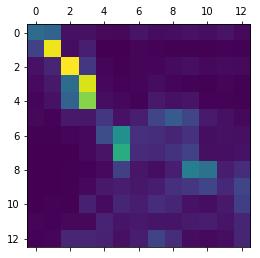

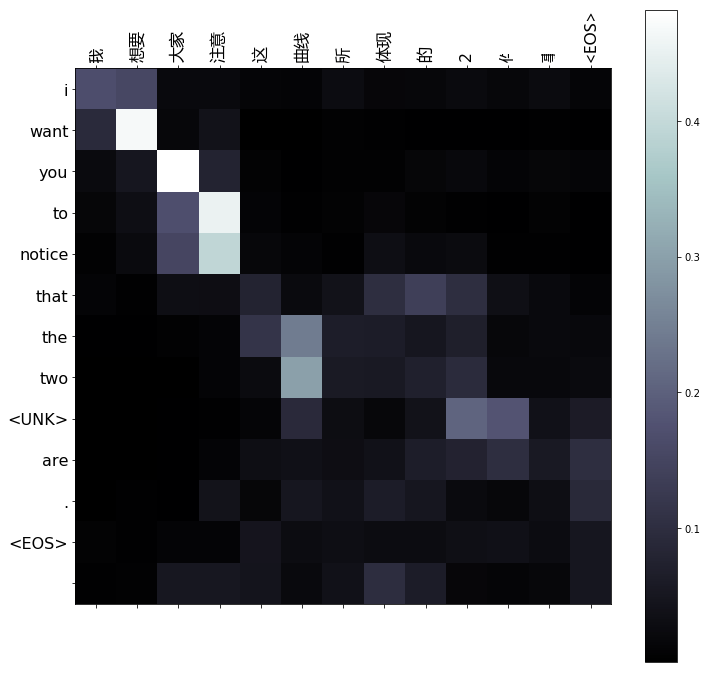

In [14]:
showAttention(source, decoded_words, decoder_attentions)

In [15]:
print(source)
print(decoded_words)

我 想要 大家 注意 这 曲线 所 体现 的 2 件 事
['i', 'want', 'you', 'to', 'notice', 'that', 'the', 'two', '<UNK>', 'are', '.', '<EOS>']


In [ ]:
class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_idx, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            return -100000
            #raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size):
        #topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_idx:
                terminates.append(([dataset['tgt'].idx2token[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) # tuple(word_list, score_float
                continue
            idxes = self.sentence_idxes[:] # pass by value
            scores = self.sentence_scores[:] # pass by value
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self):
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_idx:
                words.append('<EOS>')
            else:
                words.append(dataset['tgt'].idx2token[self.sentence_idxes[i].item()])
        if self.sentence_idxes[-1] != EOS_idx:
            words.append('<EOS>')
        return (words, self.avgScore())

def beam_decode(decoder, decoder_hidden, encoder_outputs, beam_size, cur_batch_size, max_length=MAX_SENTENCE_LENGTH):
    terminal_sentences, prev_top_sentences, next_top_sentences = [], [], []
    prev_top_sentences.append(Sentence(decoder_hidden))
    for i in range(max_length):
        for sentence in prev_top_sentences:
            decoder_input = torch.tensor(np.array([[sentence.last_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
            #decoder_input = torch.LongTensor([[sentence.last_idx]])
            #decoder_input = decoder_input.to(device)
            decoder_hidden = sentence.decoder_hidden
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(beam_size)
            term, top = sentence.addTopk(topi, topv, decoder_hidden, beam_size)
            terminal_sentences.extend(term)
            next_top_sentences.extend(top)

        next_top_sentences.sort(key=lambda s: s.avgScore(), reverse=True)
        prev_top_sentences = next_top_sentences[:beam_size]
        next_top_sentences = []

    terminal_sentences += [sentence.toWordScore() for sentence in prev_top_sentences]
    terminal_sentences.sort(key=lambda x: x[1], reverse=True)
    n = 1
    return terminal_sentences[:1]

def evaluate_beam(encoder, decoder, loader, beam_size, max_length=MAX_SENTENCE_LENGTH):
    encoder.eval()
    decoder.eval()
    input_words = []
    target_words = []
    decoded_words = []
    num_count = 0
    for i, (source, translate) in enumerate(loader):
        cur_batch_size = translate.size()[0]
        with torch.no_grad():
            encoder_hidden = encoder.init_hidden(cur_batch_size)
            
        for i in range(cur_batch_size):
            input_words.append([])
            target_words.append([])
        
        for i in range(cur_batch_size):
            for ii in range(source.size()[1]):
                if dataset['src'].idx2token[source.cpu().numpy()[i,ii]] != '<PAD>':
                    input_words[num_count].append(dataset['src'].idx2token[source.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size
        for i in range(cur_batch_size):
            for ii in range(translate.size()[1]):
                if dataset['tgt'].idx2token[translate.cpu().numpy()[i,ii]] != '<PAD>':
                    target_words[num_count].append(dataset['tgt'].idx2token[translate.cpu().numpy()[i,ii]])
            num_count += 1
        
        encoder_outputs, encoder_hidden = encoder(source, encoder_hidden)
        
        decoder_hidden = encoder_hidden
        
        decoded_words.append(beam_decode(decoder, decoder_hidden, encoder_outputs, beam_size, cur_batch_size))
        
    pre_list = []
    for i in range(len(decoded_words)):
        pre_list.append("".join([" "+ i if not i.startswith("'") and i not in string.punctuation else i for i in decoded_words[i][0][0]]).strip())
    
    true_list = []
    for true_sentenc in target_words:
        true_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in true_sentenc]).strip())
    
    score = sacrebleu.corpus_bleu(pre_list, [true_list])
    print('bleu score: ', score.score)
    
    return decoded_words, target_words, score

In [ ]:
test_dataset2 = LanguageDataset(dataset['src'].test_idx, dataset['tgt'].test_idx)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset2,
                                           batch_size=1,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [ ]:
decoded_words = evaluate_beam(encoder, decoder, test_loader2, beam_size=3, max_length=MAX_SENTENCE_LENGTH)